<a id='home'></a>

# Growth of File Sizes for Versioned-HDF5 Files 

For these tests, we have generated `.h5` data files using the `generate_data_deterministic.py` script from the [VersionedHDF5 repository](https://github.com/Quansight/versioned-hdf5), using the standard options ([see details here](#standard))

We performed the following tests:
1. [Test Large Fraction Changes Sparse](#test1)
2. [Test Mostly Appends Sparse](#test2)
3. [Test Small Fraction Changes Sparse](#test3)
4. [Test Mostly Appends Dense](#test4)

**These tests were last run on**

In [1]:
from datetime import datetime
print(datetime.utcnow(), "UTC")

2020-04-08 22:05:57.885460 UTC


## Setup

The path to the generated test files is

In [2]:
path = "/home/melissa/projects/versioned-hdf5/analysis" # change this as necessary

In [3]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import pickle
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from versioned_hdf5 import VersionedHDF5File
from generate_data_deterministic import TestVersionedDatasetPerformance

In [4]:
# auxiliary code to format file sizes 
def format_size(size):
    suffixes = ['B', 'KB', 'MB', 'GB']
    i = 0
    while size >= 1024 and i < len(suffixes)-1:
        size = size/1024
        i += 1
    return f"{size:.2f} {suffixes[i]}"

<a id='test1'></a>

# Test 1: Large fraction changes (sparse)

In [5]:
testname = "test_large_fraction_changes_sparse"

We have tested the following numbers of versions (or transactions):

```python
num_transactions_1 = [50, 100, 500, 1000, 5000, 10000]
```

Modify `num_transactions_1` for the desired tests. **Please keep in mind that file sizes can become very large for large numbers of transactions (above 5000 transactions).**

In [6]:
num_transactions_1 = [50, 100, 500]

For the chunk size parameter, we have tested chunk sizes of $2^8, 2^{10}, 2^{12}$ and $2^{14}$.

In [83]:
exponents = [8, 10, 12, 14]

Choose desired compression algorithm.

In [19]:
compression = [None, "gzip", "lzf"]

In [20]:
# Create files and set up dictionary with test info.
tests_complete = []
for c in compression:
    for p in exponents:
        for n in num_transactions_1:
            chunk_size = 2**p
            name = f"{testname}_{n}_{p}_{c}"
            filename = os.path.join(path, f"{name}.h5")
            print("File with\n" \
                  f"- {n} transactions\n" \
                  f"- chunk size 2**{p}\n"\
                  f"- compression filter {c}")
            try:
                h5pyfile = h5py.File(filename, 'r')
                print("already exists - unable to compute creation time.")
                t = 0
            except:
                print("not available. Creating new file.")
                t0 = time.time()
                TestVersionedDatasetPerformance().test_large_fraction_changes_sparse(n, name, chunk_size, c)
                t = time.time()-t0
                h5pyfile = h5py.File(filename, 'r')
            data = VersionedHDF5File(h5pyfile)
            tests_complete.append(dict(num_transactions=n, 
                                       chunk_size=chunk_size, 
                                       filename=filename, 
                                       h5pyfile=h5pyfile, 
                                       data=data, 
                                       t_write=t))

File with
- 50 transactions
- chunk size 2**12
- compression filter None
not available. Creating new file.
File with
- 100 transactions
- chunk size 2**12
- compression filter None
not available. Creating new file.
File with
- 500 transactions
- chunk size 2**12
- compression filter None
not available. Creating new file.
File with
- 50 transactions
- chunk size 2**14
- compression filter None
already exists - unable to compute creation time.
File with
- 100 transactions
- chunk size 2**14
- compression filter None
already exists - unable to compute creation time.
File with
- 500 transactions
- chunk size 2**14
- compression filter None
already exists - unable to compute creation time.
File with
- 50 transactions
- chunk size 2**12
- compression filter gzip
not available. Creating new file.
File with
- 100 transactions
- chunk size 2**12
- compression filter gzip
not available. Creating new file.
File with
- 500 transactions
- chunk size 2**12
- compression filter gzip
not available. Cr

## Number of versions v. File size

We'll start by analyzing how the `.h5` file sizes grow as the number of versions grows. 

In [21]:
for test in tests_complete:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])

Note that the array size also grows as the number of versions grows, since each transaction is changing the original arrays by adding, deleting and changing values in the original arrays. In order to compute a (naive) theoretical lower bound on the file size, we'll compute how much space each version should take. Keep in mind there is redundant data as some of it is not changed during the staging of a new version but it is still being stored. In this example, we start with three arrays with 5000 elements (2 integer arrays and one float), and in the end we have the following array sizes:

In [22]:
n = len(num_transactions_1)
# We take just the last n items in test_complete because usually 
# they will be the fastest to read/write 
for test in tests_complete[-n:]:
    lengths = []
    total_size = 0
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
            total_size += len(version[group_key]['val'])
    test['theoretical_sizes'] = 24*total_size
    print(f"Maximum array size for file with {test['num_transactions']} transactions: {max(lengths)}")

Maximum array size for file with 50 transactions: 5500
Maximum array size for file with 100 transactions: 6000
Maximum array size for file with 500 transactions: 10000


(Note also that changing the chunking parameter does not change the size of the arrays, so we read the file with chunksize $2^{14}$ since we have observed faster read times for this file.)

For larger values we have something like this:
```
Maximum array size for file with 50 transactions: 5500
Maximum array size for file with 100 transactions: 6000
Maximum array size for file with 500 transactions: 10000
Maximum array size for file with 1000 transactions: 15000
Maximum array size for file with 5000 transactions: 55000
Maximum array size for file with 10000 transactions: 105000
```

In [23]:
t_sizes_1 = [test['theoretical_sizes'] for test in tests_complete[-n:]]

In [24]:
# Removing some irrelevant info from the dictionary 
test_large_fraction_changes_sparse = []
for test in tests_complete:
    test_large_fraction_changes_sparse.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label', 't_write']))

Let's show the size information in a plot:

ValueError: x and y must have same first dimension, but have shapes (6,) and (3,)

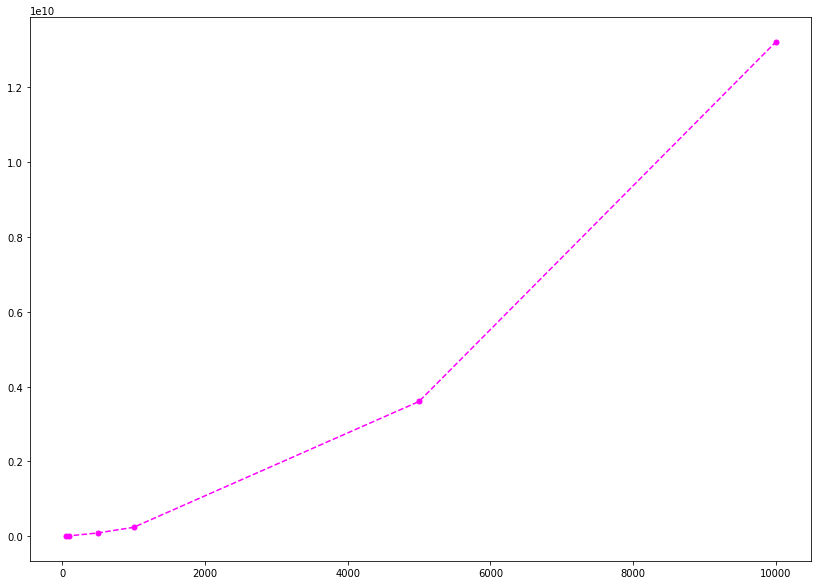

In [84]:
filesizes_1 = np.array([test['size'] for test in test_large_fraction_changes_sparse])
sizelabels_1 = np.array([test['size_label'] for test in test_large_fraction_changes_sparse])

fig_large_fraction_changes = plt.figure(figsize=(14,10))
plt.plot(num_transactions_1, t_sizes_1, 'o--', ms=5, color='magenta', label="Theoretical file size")

nexp = len(exponents)
for i in range(len(compression)):
    for j in range(nexp):
        plt.plot(num_transactions_1, filesizes_1[j*n+i*nexp*n:(j+1)*n+i*nexp*n], '*--', ms=12, label=f"Chunk size 2**{exponents[j]}, {compression[i]}")

plt.xlabel("Transactions")
plt.title("test_large_fraction_changes_sparse")
plt.legend()
labels = [0, 2, 3, 4, 5, 8, 17]
plt.yticks(filesizes_1[labels], sizelabels_1[labels])
plt.show()

Changing the view to a logarithmic scale, we have the following:

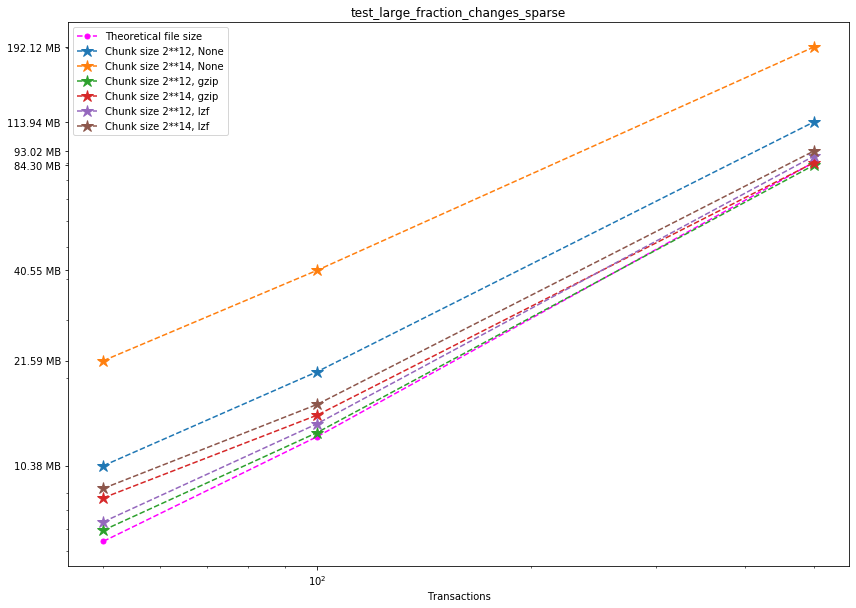

In [75]:
fig_large_fraction_changes_log = plt.figure(figsize=(14,10))
plt.loglog(num_transactions_1, t_sizes_1, 'o--', ms=5, color='magenta', label="Theoretical file size")

for i in range(len(compression)):
    for j in range(nexp):
        plt.loglog(num_transactions_1, filesizes_1[j*n+i*nexp*n:(j+1)*n+i*nexp*n], '*--', ms=12, label=f"Chunk size 2**{exponents[j]}, {compression[i]}")

plt.xlabel("Transactions")
plt.title("test_large_fraction_changes_sparse")
plt.legend()
labels = [0, 2, 3, 4, 5, 8, 17]
plt.yticks(filesizes_1[labels], sizelabels_1[labels])
plt.show()

## Creation times

If we look at the creation times for these files, we have something like this:

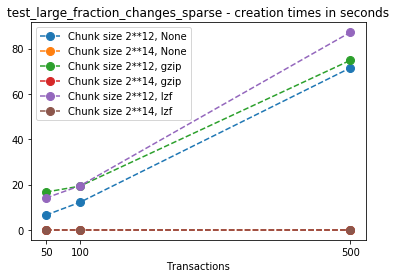

In [76]:
t_write_1 = np.array([test['t_write'] for test in test_large_fraction_changes_sparse])

fig_large_fraction_changes_times = plt.figure()
for i in range(len(compression)):
    for j in range(nexp):
        plt.plot(num_transactions_1, t_write_1[j*n+i*nexp*n:(j+1)*n+i*nexp*n], 'o--', ms=8, label=f"Chunk size 2**{exponents[j]}, {compression[i]}")
plt.xlabel("Transactions")
plt.title("test_large_fraction_changes_sparse - creation times in seconds")
plt.legend()
plt.xticks(num_transactions_1)
plt.show()

So we can clearly see that files with smallest file size, corresponding to chunk sizes of $2^8$ and $2^{10}$, are also the ones with largest creation times. **This is consistent with the effects of using smaller chunk sizes in HDF5 files.**

## Large tests

Previously executed tests (with no compression), with larger numbers of transactions, gave us the following:

In [78]:
with open("test_large_fraction_changes_sparse_versions_8.pickle", "rb") as pickle_in:
    test_large_fraction_changes_sparse_8 = pickle.load(pickle_in)
with open("test_large_fraction_changes_sparse_versions_10.pickle", "rb") as pickle_in:
    test_large_fraction_changes_sparse_10 = pickle.load(pickle_in)
with open("test_large_fraction_changes_sparse_versions_12.pickle", "rb") as pickle_in:
    test_large_fraction_changes_sparse_12 = pickle.load(pickle_in)
with open("test_large_fraction_changes_sparse_versions_14.pickle", "rb") as pickle_in:
    test_large_fraction_changes_sparse_14 = pickle.load(pickle_in)

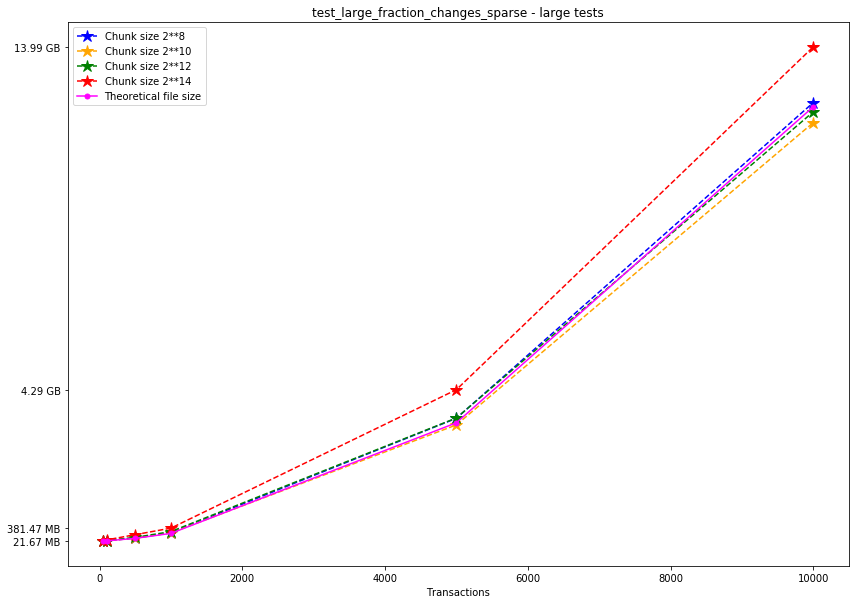

In [79]:
num_transactions_1 = [50, 100, 500, 1000, 5000, 10000]
# Previously computed theoretical sizes
t_sizes_1 = [6426000, 13332000, 90180000, 240240000, 3600720000, 13201320000]

filesizes_1_8 = np.array([test['size'] for test in test_large_fraction_changes_sparse_8])
sizelabels_1_8 = np.array([test['size_label'] for test in test_large_fraction_changes_sparse_8])

filesizes_1_10 = np.array([test['size'] for test in test_large_fraction_changes_sparse_10])
sizelabels_1_10 = np.array([test['size_label'] for test in test_large_fraction_changes_sparse_10])

filesizes_1_12 = np.array([test['size'] for test in test_large_fraction_changes_sparse_12])
sizelabels_1_12 = np.array([test['size_label'] for test in test_large_fraction_changes_sparse_12])

filesizes_1_14 = np.array([test['size'] for test in test_large_fraction_changes_sparse_14])
sizelabels_1_14 = np.array([test['size_label'] for test in test_large_fraction_changes_sparse_14])

fig_large_fraction_changes_pickled = plt.figure(figsize=(14,10))
plt.plot(num_transactions_1, filesizes_1_8, '*--', color='blue', ms=12, label="Chunk size 2**8")
plt.plot(num_transactions_1, filesizes_1_10, '*--', color='orange', ms=12, label="Chunk size 2**10")
plt.plot(num_transactions_1, filesizes_1_12, '*--', color='green', ms=12, label="Chunk size 2**12")
plt.plot(num_transactions_1, filesizes_1_14, '*--', color='red', ms=12, label="Chunk size 2**14")
plt.plot(num_transactions_1, t_sizes_1, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xlabel("Transactions")
plt.title("test_large_fraction_changes_sparse - large tests")
plt.legend()
labels = [0, 3, 4, 5]
plt.yticks(filesizes_1_14[labels], sizelabels_1_14[labels])
plt.show()

In a log plot:

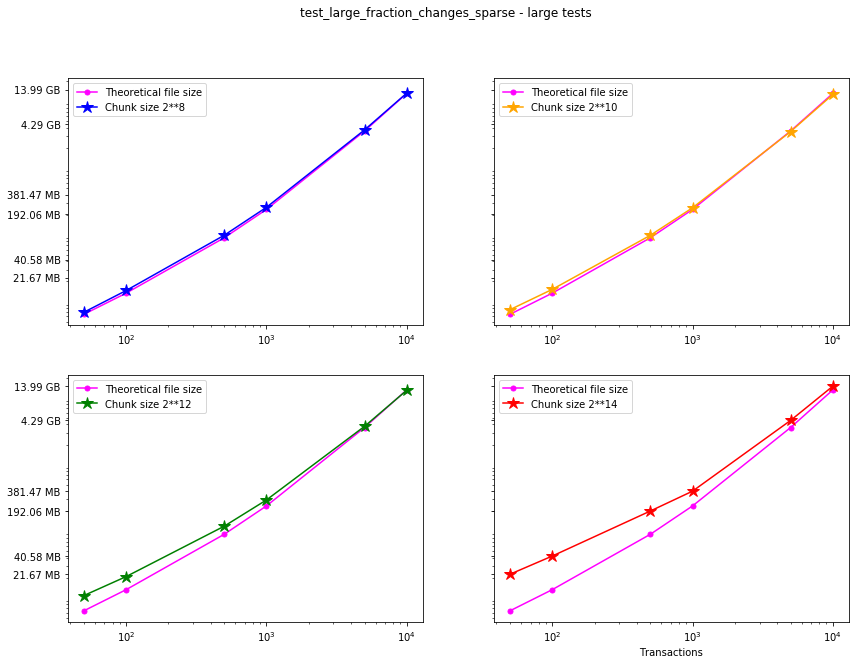

In [80]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10), sharey=True)

ax1.loglog(num_transactions_1, t_sizes_1, 'o-', ms=5, color='magenta', label="Theoretical file size")
ax1.loglog(num_transactions_1, filesizes_1_8, '*-', ms=12, color='blue', label="Chunk size 2**8")
ax1.legend()

ax2.loglog(num_transactions_1, t_sizes_1, 'o-', ms=5, color='magenta', label="Theoretical file size")
ax2.loglog(num_transactions_1, filesizes_1_10, '*-', ms=12, color='orange', label="Chunk size 2**10")
ax2.legend()

ax3.loglog(num_transactions_1, t_sizes_1, 'o-', ms=5, color='magenta', label="Theoretical file size")
ax3.loglog(num_transactions_1, filesizes_1_12, '*-', ms=12, color='green', label="Chunk size 2**12")
ax3.legend()

ax4.loglog(num_transactions_1, t_sizes_1, 'o-', ms=5, color='magenta', label="Theoretical file size")
ax4.loglog(num_transactions_1, filesizes_1_14, '*-', ms=12, color='red', label="Chunk size 2**14")
ax4.legend()

plt.xlabel("Transactions")
f.suptitle("test_large_fraction_changes_sparse - large tests")

plt.yticks(filesizes_1_14, sizelabels_1_14)
plt.show()

This behaviour suggests that for `test_large_fraction_changes_sparse`, larger chunk sizes generate larger files, but the size of the files grows modestly as the number of transactions grow. So, **if we are dealing with a large number of transactions, larger chunk sizes generate files that are of reasonable size while having faster creation times** (and probably faster IO speeds as well).

### Finishing up

In [81]:
for test in tests_complete:
    test['h5pyfile'].close()

[Back to top](#home)

<a id='test2'></a>

# Test 2: Mostly appends (sparse)

In [85]:
testname = "test_mostly_appends_sparse"

For this case, we have tested the following number of transactions:

```python
num_transactions_2 = [50, 100, 200]
```

Once again, we tested chunk sizes of $2^8$, $2^{10}$, $2^{12}$ and $2^{14}$.

Change `num_transactions_2` and `exponents` as desired (the previous warning applies: beware of very large file sizes and creation times for large numbers of versions):

In [86]:
num_transactions_2 = [50, 100, 200]
#exponents = [8, 10, 12, 14]
exponents = [12, 14]
compression = [None, "gzip", "lzf"]

In [ ]:
# Create files and set up dictionary with test info.
tests_complete = []
for c in compression:
    for p in exponents:
        for n in num_transactions_2:
            chunk_size = 2**p
            name = f"{testname}_{n}_{p}_{c}"
            filename = os.path.join(path, f"{name}.h5")
            print("File with\n" \
                  f"- {n} transactions\n" \
                  f"- chunk size 2**{p}\n"\
                  f"- compression filter {c}")
            try:
                h5pyfile = h5py.File(filename, 'r')
                print("already exists - unable to compute creation time.")
                t = 0
            except:
                print("not available. Creating new file.")
                t0 = time.time()
                TestVersionedDatasetPerformance().test_mostly_appends_sparse(n, name, chunk_size, c)
                t = time.time()-t0
                h5pyfile = h5py.File(filename, 'r')
            data = VersionedHDF5File(h5pyfile)
            tests_complete.append(dict(num_transactions=n, 
                                       chunk_size=chunk_size, 
                                       filename=filename, 
                                       h5pyfile=h5pyfile, 
                                       data=data, 
                                       t_write=t))

File with
- 50 transactions
- chunk size 2**12
- compression filter None
not available. Creating new file.
File with
- 100 transactions
- chunk size 2**12
- compression filter None
not available. Creating new file.
File with
- 200 transactions
- chunk size 2**12
- compression filter None
not available. Creating new file.


In [22]:
# Compute sizes
for test in tests_complete:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])
    
n = len(num_transactions_2)
# We take just the last n items in test_complete because usually 
# they will be the fastest to read/write 
for test in tests_complete[-n:]:
    lengths = []
    total_size = 0
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
            total_size += len(version[group_key]['val'])
    test['theoretical_sizes'] = 24*total_size
    print(f"Maximum array size for file with {test['num_transactions']}: {max(lengths)}")

Maximum array size for file with 50: 51000
Maximum array size for file with 100: 101000
Maximum array size for file with 200: 201000


In [23]:
t_sizes_2 = [test['theoretical_sizes'] for test in tests_complete[-n:]]

In [24]:
# Removing irrelevant information from the test dictionary
test_mostly_appends_sparse = []
for test in tests_complete:
    test_mostly_appends_sparse.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label', 't_write']))

Let's show the size information in a graph:

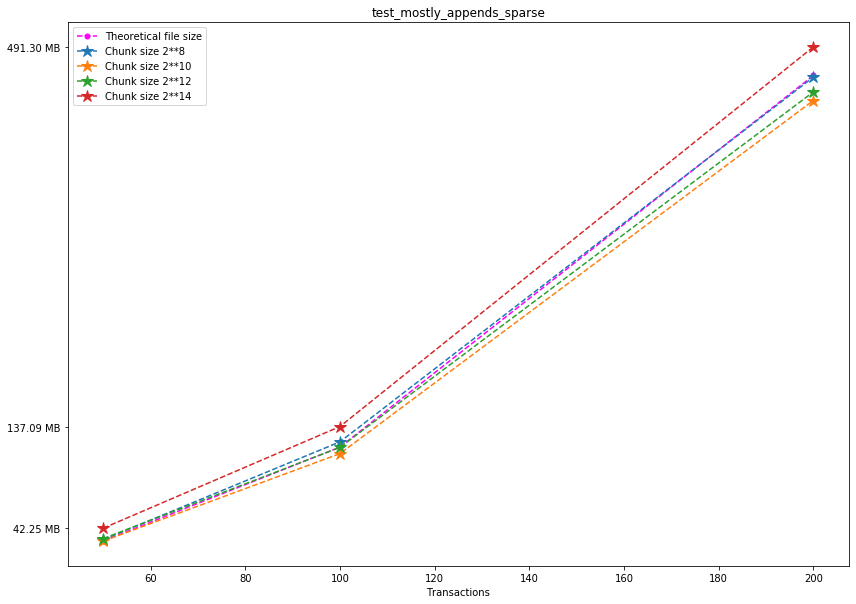

In [25]:
filesizes_2 = np.array([test['size'] for test in test_mostly_appends_sparse])
sizelabels_2 = np.array([test['size_label'] for test in test_mostly_appends_sparse])

fig_mostly_appends = plt.figure(figsize=(14,10))
plt.plot(num_transactions_2, t_sizes_2, 'o--', ms=5, color='magenta', label="Theoretical file size")

nexp = len(exponents)
for i in range(len(compression)):
    for j in range(nexp):
        plt.plot(num_transactions_2, filesizes_2[j*n+i*nexp*n:(j+1)*n+i*nexp*n], '*--', ms=12, label=f"Chunk size 2**{exponents[j]}, {compression[i]}")

    
plt.xlabel("Transactions")
plt.title("test_mostly_appends_sparse")
plt.legend()
plt.yticks(filesizes_2[-n:], sizelabels_2[-n:])
plt.show()

Changing the view to a logarithmic scale, we have the following:

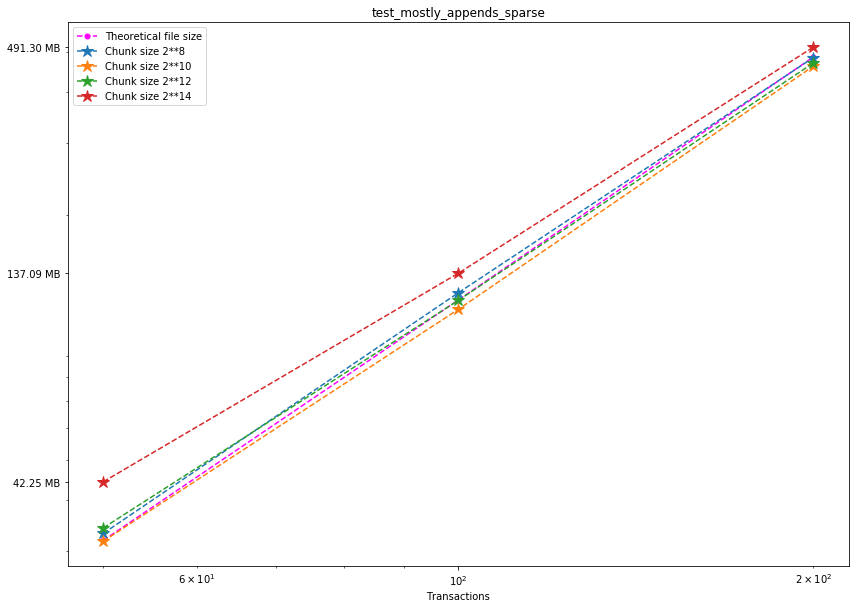

In [26]:
fig_mostly_appends_log = plt.figure(figsize=(14,10))
plt.loglog(num_transactions_2, t_sizes_2, 'o--', ms=5, color='magenta', label="Theoretical file size")

for i in range(len(exponents)):
    plt.loglog(num_transactions_2, filesizes_2[i*n:(i+1)*n], '*--', ms=12, label=f"Chunk size 2**{exponents[i]}")

plt.xlabel("Transactions")
plt.title("test_mostly_appends_sparse")
plt.legend()
plt.yticks(filesizes_2[-n:], sizelabels_2[-n:])
plt.show()

If we look at the creation times for these files, we have something like this:

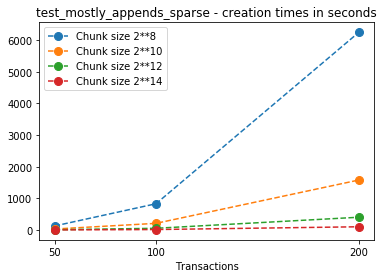

In [27]:
t_write_2 = np.array([test['t_write'] for test in test_mostly_appends_sparse])

fig_mostly_appends_times = plt.figure()
for i in range(len(exponents)):
    plt.plot(num_transactions_2, t_write_2[i*n:(i+1)*n], 'o--', ms=8, label=f"Chunk size 2**{exponents[i]}")
plt.xlabel("Transactions")
plt.title("test_mostly_appends_sparse - creation times in seconds")
plt.legend()
plt.xticks(num_transactions_2)
plt.show()

The result is similar to the first test: smaller chunk sizes correspond to smaller file sizes, but larger creation times.

### Finishing up

In [28]:
for test in tests_complete:
    test['h5pyfile'].close()

[Back to top](#home)

<a id='test3'></a>

# Test 3: Small fraction changes (sparse)

In [58]:
testname = "test_small_fraction_changes_sparse"

We have tested the following numbers of versions (or transactions):

```python
num_transactions_3 = [50, 100, 500, 1000, 5000]
```

Change `num_transactions_3` and `exponents` as desired:

In [61]:
num_transactions_3 = [50, 100, 500]
exponents = [8, 10, 12, 14]

In [62]:
# Create files and setup dictionary with test info
tests_complete = []
for p in exponents:
    for n in num_transactions_3:
        chunk_size = 2**p
        name = f"{testname}_{n}_{p}"
        filename = os.path.join(path, f"{name}.h5")
        try:
            h5pyfile = h5py.File(filename, 'r')
            print(f"File with {n} transactions and chunk size 2**{p} already exists - unable to compute creation time.")
            t = 0
        except:
            print(f"File with {n} transactions and chunk size 2**{p} not available. Creating new file ")
            t0 = time.time()
            TestVersionedDatasetPerformance().test_small_fraction_changes_sparse(n, name, chunk_size)
            t = time.time()-t0
            h5pyfile = h5py.File(filename, 'r')
        data = VersionedHDF5File(h5pyfile)
        tests_complete.append(dict(num_transactions=n, chunk_size=chunk_size, filename=filename, h5pyfile=h5pyfile, data=data, t_write=t))

File with 50 transactions and chunk size 2**8 not available. Creating new file 
File with 100 transactions and chunk size 2**8 not available. Creating new file 
File with 500 transactions and chunk size 2**8 not available. Creating new file 
File with 1000 transactions and chunk size 2**8 not available. Creating new file 
File with 5000 transactions and chunk size 2**8 not available. Creating new file 
File with 50 transactions and chunk size 2**10 not available. Creating new file 
File with 100 transactions and chunk size 2**10 not available. Creating new file 
File with 500 transactions and chunk size 2**10 not available. Creating new file 
File with 1000 transactions and chunk size 2**10 not available. Creating new file 
File with 5000 transactions and chunk size 2**10 not available. Creating new file 
File with 50 transactions and chunk size 2**12 not available. Creating new file 
File with 100 transactions and chunk size 2**12 not available. Creating new file 
File with 500 transa

In [63]:
# Compute sizes
for test in tests_complete:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])
    
n = len(num_transactions_3)
for test in tests_complete[-n:]:
    lengths = []
    total_size = 0
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
            total_size += len(version[group_key]['val'])
    test['theoretical_sizes'] = 24*total_size
    print(f"Maximum array size for file with {test['num_transactions']}: {max(lengths)}")

Maximum array size for file with 50: 5500
Maximum array size for file with 100: 6000
Maximum array size for file with 500: 10000
Maximum array size for file with 1000: 15000
Maximum array size for file with 5000: 55000


Note that changing the chunking parameter does not change the size of the arrays.

In [64]:
t_sizes_3 = [test['theoretical_sizes'] for test in tests_complete[-n:]]

In [65]:
# Removing irrelevant information
test_small_fraction_changes_sparse = []
for test in tests_complete:
    test_small_fraction_changes_sparse.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label', 't_write']))

Let's show the size information in a graph:

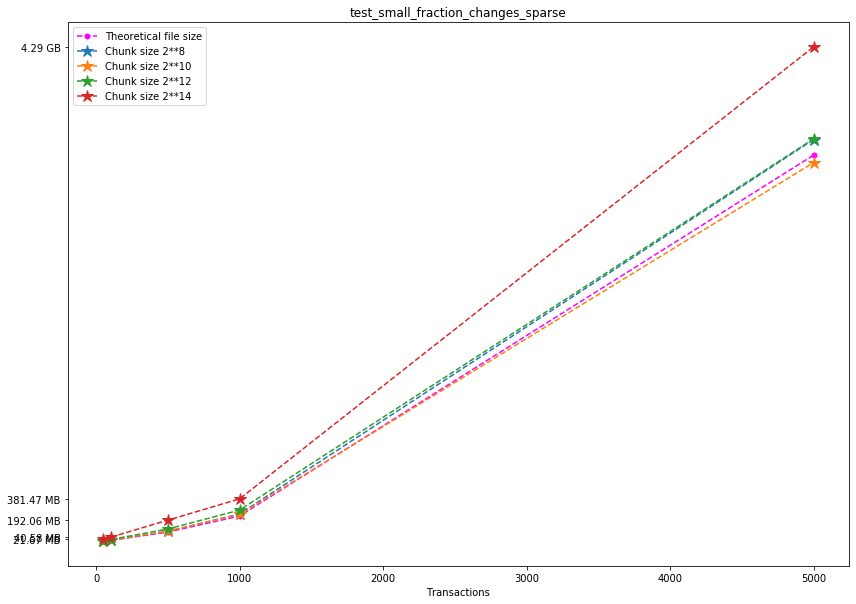

In [66]:
filesizes_3 = np.array([test['size'] for test in test_small_fraction_changes_sparse])
sizelabels_3 = np.array([test['size_label'] for test in test_small_fraction_changes_sparse])

fig_small_fraction_changes = plt.figure(figsize=(14,10))
plt.plot(num_transactions_3, t_sizes_3, 'o--', ms=5, color='magenta', label="Theoretical file size")

for i in range(len(exponents)):
    plt.plot(num_transactions_3, filesizes_3[i*n:(i+1)*n], '*--', ms=12, label=f"Chunk size 2**{exponents[i]}")

plt.xlabel("Transactions")
plt.title("test_small_fraction_changes_sparse")
plt.legend()
plt.yticks(filesizes_3[-n:], sizelabels_3[-n:])
plt.show()

Changing the view to a logarithmic scale, we have the following:

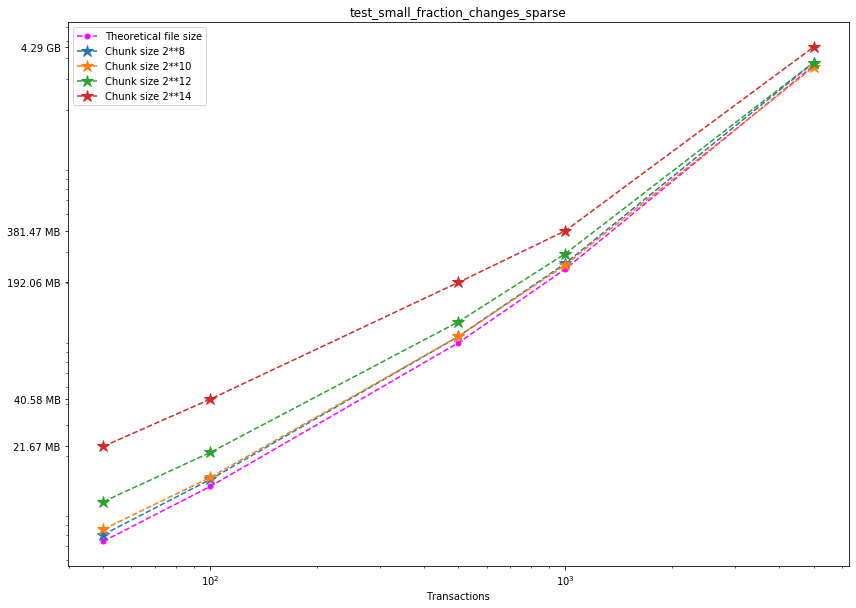

In [67]:
fig_small_fraction_changes_log = plt.figure(figsize=(14,10))
plt.loglog(num_transactions_3, t_sizes_3, 'o--', ms=5, color='magenta', label="Theoretical file size")

for i in range(len(exponents)):
    plt.loglog(num_transactions_3, filesizes_3[i*n:(i+1)*n], '*--', ms=12, label=f"Chunk size 2**{exponents[i]}")

plt.xlabel("Transactions")
plt.title("test_small_fraction_changes_sparse")
plt.legend()
plt.yticks(filesizes_3[-n:], sizelabels_3[-n:])
plt.show()

If we look at the creation times for these files, we have something like this:

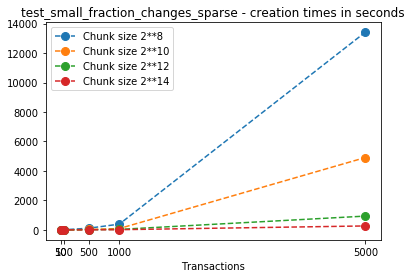

In [68]:
t_write_3 = np.array([test['t_write'] for test in test_small_fraction_changes_sparse])

fig_small_fraction_changes_times = plt.figure()
for i in range(len(exponents)):
    plt.plot(num_transactions_3, t_write_3[i*n:(i+1)*n], 'o--', ms=8, label=f"Chunk size 2**{exponents[i]}")
plt.xlabel("Transactions")
plt.title("test_small_fraction_changes_sparse - creation times in seconds")
plt.legend()
plt.xticks(num_transactions_3)
plt.show()

So we can clearly see that the files with smallest file size, corresponding to chunk sizes of $2^8$ and $2^{10}$, are also the ones with largest creation times. This is consistent with the effects of using smaller chunk sizes in HDF5 files.

## Large tests

Previously executed tests, with larger numbers of transactions, gave us the following:

In [71]:
with open("test_small_fraction_changes_sparse_versions_8.pickle", "rb") as pickle_in:
    test_small_fraction_changes_sparse_8 = pickle.load(pickle_in)
with open("test_small_fraction_changes_sparse_versions_10.pickle", "rb") as pickle_in:
    test_small_fraction_changes_sparse_10 = pickle.load(pickle_in)
with open("test_small_fraction_changes_sparse_versions_12.pickle", "rb") as pickle_in:
    test_small_fraction_changes_sparse_12 = pickle.load(pickle_in)
with open("test_small_fraction_changes_sparse_versions_14.pickle", "rb") as pickle_in:
    test_small_fraction_changes_sparse_14 = pickle.load(pickle_in)

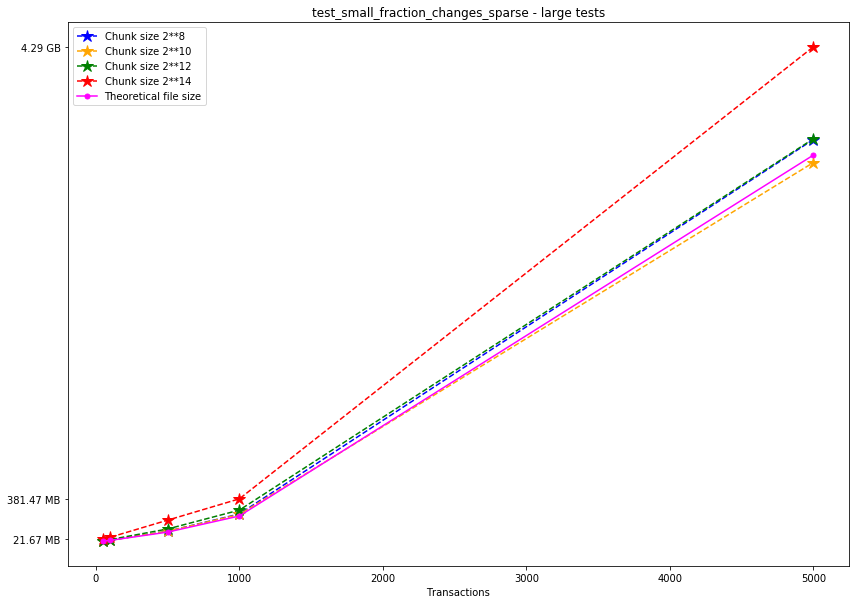

In [75]:
num_transactions_3 = [50, 100, 500, 1000, 5000]
# Previously computed theoretical sizes
t_sizes_3 = [6426000, 13332000, 90180000, 240240000, 3600720000]

filesizes_3_8 = np.array([test['size'] for test in test_small_fraction_changes_sparse_8])
sizelabels_3_8 = np.array([test['size_label'] for test in test_small_fraction_changes_sparse_8])

filesizes_3_10 = np.array([test['size'] for test in test_small_fraction_changes_sparse_10])
sizelabels_3_10 = np.array([test['size_label'] for test in test_small_fraction_changes_sparse_10])

filesizes_3_12 = np.array([test['size'] for test in test_small_fraction_changes_sparse_12])
sizelabels_3_12 = np.array([test['size_label'] for test in test_small_fraction_changes_sparse_12])

filesizes_3_14 = np.array([test['size'] for test in test_small_fraction_changes_sparse_14])
sizelabels_3_14 = np.array([test['size_label'] for test in test_small_fraction_changes_sparse_14])

fig_large_fraction_changes_pickled = plt.figure(figsize=(14,10))
plt.plot(num_transactions_3, filesizes_3_8, '*--', color='blue', ms=12, label="Chunk size 2**8")
plt.plot(num_transactions_3, filesizes_3_10, '*--', color='orange', ms=12, label="Chunk size 2**10")
plt.plot(num_transactions_3, filesizes_3_12, '*--', color='green', ms=12, label="Chunk size 2**12")
plt.plot(num_transactions_3, filesizes_3_14, '*--', color='red', ms=12, label="Chunk size 2**14")
plt.plot(num_transactions_3, t_sizes_3, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xlabel("Transactions")
plt.title("test_small_fraction_changes_sparse - large tests")
plt.legend()
plt.yticks(filesizes_3_14[[0, 3, 4]], sizelabels_3_14[[0, 3, 4]])
plt.show()

In a log plot:

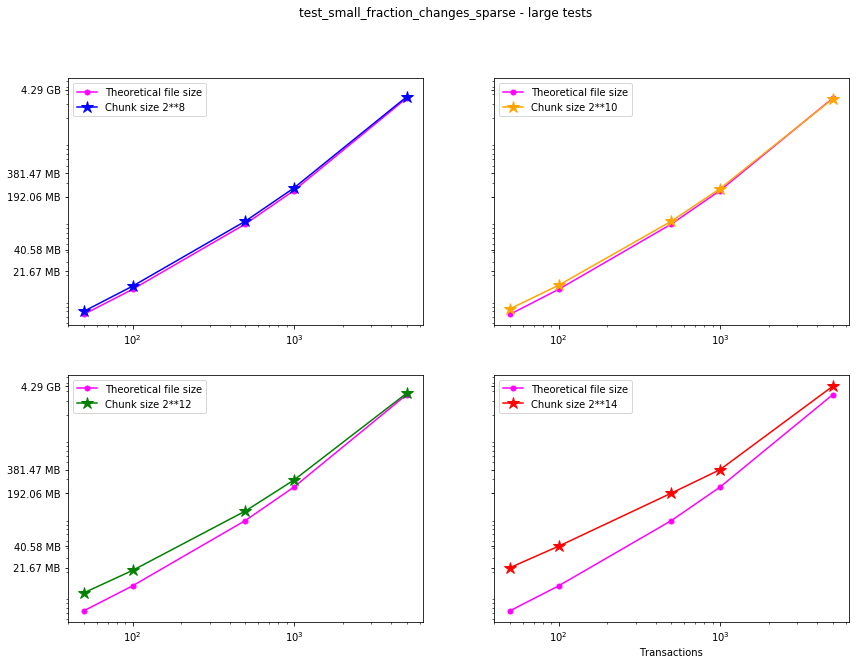

In [76]:
f2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10), sharey=True)

ax1.loglog(num_transactions_3, t_sizes_3, 'o-', ms=5, color='magenta', label="Theoretical file size")
ax1.loglog(num_transactions_3, filesizes_3_8, '*-', ms=12, color='blue', label="Chunk size 2**8")
ax1.legend()

ax2.loglog(num_transactions_3, t_sizes_3, 'o-', ms=5, color='magenta', label="Theoretical file size")
ax2.loglog(num_transactions_3, filesizes_3_10, '*-', ms=12, color='orange', label="Chunk size 2**10")
ax2.legend()

ax3.loglog(num_transactions_3, t_sizes_3, 'o-', ms=5, color='magenta', label="Theoretical file size")
ax3.loglog(num_transactions_3, filesizes_3_12, '*-', ms=12, color='green', label="Chunk size 2**12")
ax3.legend()

ax4.loglog(num_transactions_3, t_sizes_3, 'o-', ms=5, color='magenta', label="Theoretical file size")
ax4.loglog(num_transactions_3, filesizes_3_14, '*-', ms=12, color='red', label="Chunk size 2**14")
ax4.legend()

plt.xlabel("Transactions")
f2.suptitle("test_small_fraction_changes_sparse - large tests")

plt.yticks(filesizes_3_14, sizelabels_3_14)
plt.show()

This behaviour is similar to what we got in the `test_large_fraction_changes_sparse` case: for `test_small_fraction_changes_sparse`, larger chunk sizes generate larger files, but the size of the files grows modestly as the number of transactions grow. So, **if we are dealing with a large number of transactions, larger chunk sizes generate files that are of reasonable size while having faster creation times** (and probably faster IO speeds as well).

### Finishing up

In [77]:
for test in tests_complete:
    test['h5pyfile'].close()

[Back to top](#home)

<a id='test4'></a>

# Test 4: Mostly appends (dense)

In [40]:
testname = "test_mostly_appends_dense"

For this case, we have tested the following number of transactions:

```python
num_transactions_2 = [50, 100, 200]
```

Change `num_transactions_4` and `exponents` as desired:

In [41]:
num_transactions_4 = [50, 100, 200]
exponents = [8, 10, 12, 14]

In [42]:
tests_complete = []
for p in exponents:
    for n in num_transactions_4:
        chunk_size = 2**p
        name = f"{testname}_{n}_{p}"
        filename = os.path.join(path, f"{name}.h5")
        try:
            h5pyfile = h5py.File(filename, 'r')
            print(f"File with {n} transactions and chunk size 2**{p} already exists - unable to compute creation time.")
            t = 0
        except:
            print(f"File with {n} transactions and chunk size 2**{p} not available. Creating new file ")
            t0 = time.time()
            TestVersionedDatasetPerformance().test_mostly_appends_dense(n, name, chunk_size)
            t = time.time()-t0
            h5pyfile = h5py.File(filename, 'r')
        data = VersionedHDF5File(h5pyfile)
        tests_complete.append(dict(num_transactions=n, chunk_size=chunk_size, filename=filename, h5pyfile=h5pyfile, data=data, t_write=t))

File with 50 transactions and chunk size 2**8 not available. Creating new file 
File with 100 transactions and chunk size 2**8 not available. Creating new file 
File with 200 transactions and chunk size 2**8 not available. Creating new file 
File with 50 transactions and chunk size 2**10 not available. Creating new file 
File with 100 transactions and chunk size 2**10 not available. Creating new file 
File with 200 transactions and chunk size 2**10 not available. Creating new file 
File with 50 transactions and chunk size 2**12 not available. Creating new file 
File with 100 transactions and chunk size 2**12 not available. Creating new file 
File with 200 transactions and chunk size 2**12 not available. Creating new file 
File with 50 transactions and chunk size 2**14 not available. Creating new file 
File with 100 transactions and chunk size 2**14 not available. Creating new file 
File with 200 transactions and chunk size 2**14 not available. Creating new file 


In [43]:
for test in tests_complete:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])

In [56]:
n = len(num_transactions_4)
for test in tests_complete[-n:]:
    lengths = []
    total_size = 0
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
            total_size += len(version[group_key]['val'])
    test['theoretical_sizes'] = 24*total_size
    print(f"Maximum array size for file with {test['num_transactions']} transactions: {max(lengths)}")

Maximum array size for file with 50 transactions: 38400
Maximum array size for file with 100 transactions: 120900
Maximum array size for file with 200 transactions: 420900


Note that changing the chunking parameter does not change the size of the arrays.

In [51]:
t_sizes_4 = [test['theoretical_sizes'] for test in tests_complete[-n:]]

In [52]:
test_mostly_appends_dense = []
for test in tests_complete:
    test_mostly_appends_dense.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label', 't_write']))

Let's show the size information in a graph:

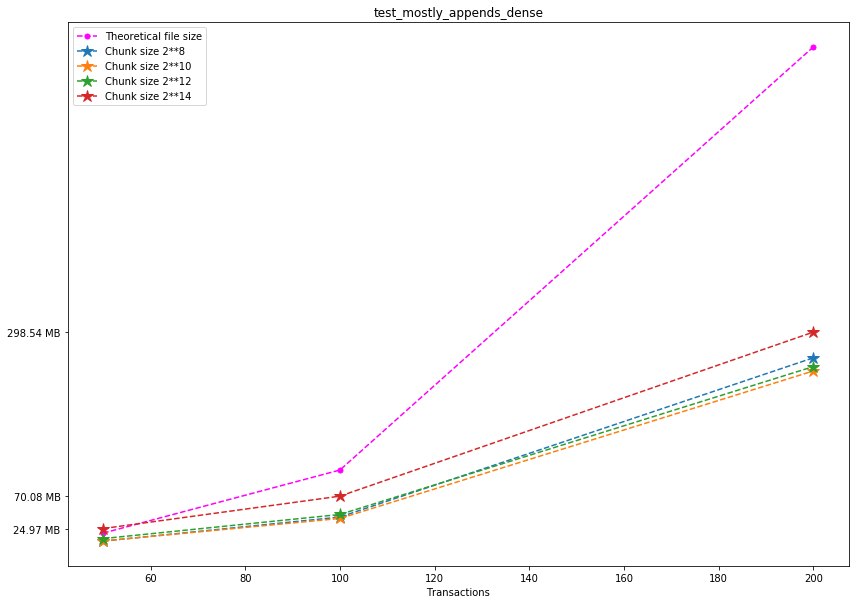

In [53]:
filesizes_4 = np.array([test['size'] for test in test_mostly_appends_dense])
sizelabels_4 = np.array([test['size_label'] for test in test_mostly_appends_dense])

fig_mostly_appends_dense = plt.figure(figsize=(14,10))
plt.plot(num_transactions_4, t_sizes_4, 'o--', ms=5, color='magenta', label="Theoretical file size")

for i in range(len(exponents)):
    plt.plot(num_transactions_4, filesizes_4[i*n:(i+1)*n], '*--', ms=12, label=f"Chunk size 2**{exponents[i]}")

plt.xlabel("Transactions")
plt.title("test_mostly_appends_dense")
plt.legend()
plt.yticks(filesizes_4[-n:], sizelabels_4[-n:])
plt.show()

Changing the view to a logarithmic scale, we have the following:

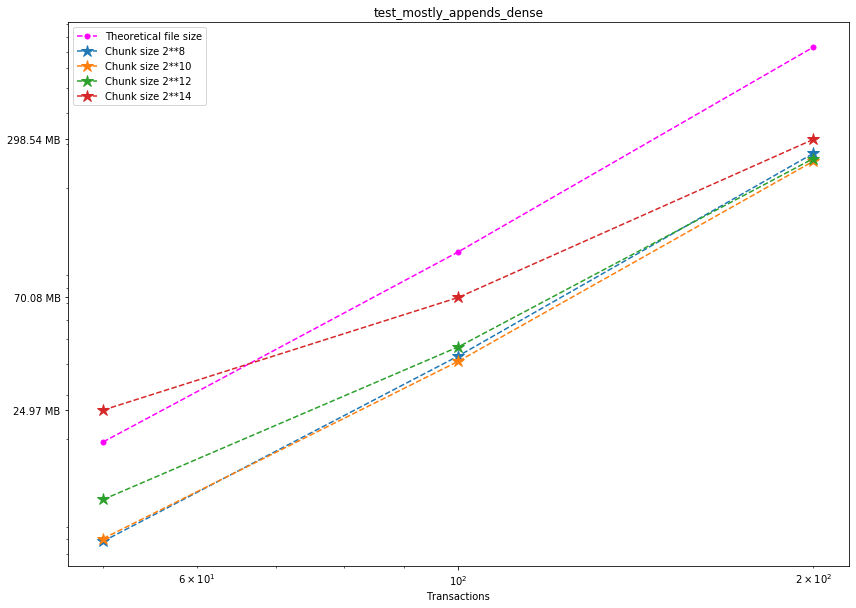

In [54]:
fig_mostly_appends_dense_log = plt.figure(figsize=(14,10))

plt.loglog(num_transactions_4, t_sizes_4, 'o--', ms=5, color='magenta', label="Theoretical file size")

for i in range(len(exponents)):
    plt.loglog(num_transactions_4, filesizes_4[i*n:(i+1)*n], '*--', ms=12, label=f"Chunk size 2**{exponents[i]}")

plt.xlabel("Transactions")
plt.title("test_mostly_appends_dense")
plt.legend()
plt.yticks(filesizes_4[-n:], sizelabels_4[-n:])
plt.show()

If we look at the creation times for these files, we have something like this:

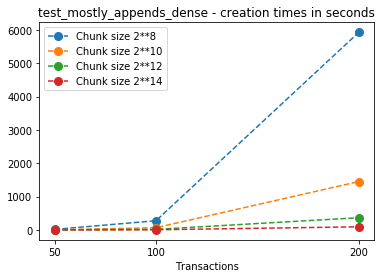

In [55]:
t_write_4 = np.array([test['t_write'] for test in test_mostly_appends_dense])

fig_mostly_appends_dense_times = plt.figure()
for i in range(len(exponents)):
    plt.plot(num_transactions_4, t_write_4[i*n:(i+1)*n], 'o--', ms=8, label=f"Chunk size 2**{exponents[i]}")
plt.xlabel("Transactions")
plt.title("test_mostly_appends_dense - creation times in seconds")
plt.legend()
plt.xticks(num_transactions_4)
plt.show()

The behaviour is similar to what we observed in other tests.

### Finishing up

In [57]:
for test in tests_complete:
    test['h5pyfile'].close()

[Back to top](#home)

## Understanding each file

Each versioned HDF5 file contains 3 datasets per version:
- `key0`, an array of `int64`
- `key1`, an array of `int64`
- `val`, an array of `float64`
plus metadata about groups, datasets and versions.

This means that each file has  

```
nversions * 24 * arraysize + metadata
```
bytes of information.

<a id='standard'></a>
## Standard parameters

- `test_large_fraction_changes_sparse`: 
    - `num_rows_initial = 5000`
    - `num_rows_per_append = 10`
    - `num_inserts = 10`
    - `num_deletes = 10`
    - `num_changes = 1000`
- `test_small_fraction_changes_sparse`
    - `num_rows_initial = 5000`
    - `num_rows_per_append = 10`
    - `num_inserts = 10`
    - `num_deletes = 10`
    - `num_changes = 10`
- `test_mostly_appends_sparse`:
    - `num_rows_initial = 1000`
    - `num_rows_per_append = 1000`
    - `num_inserts = 10`
    - `num_deletes = 10`
    - `num_changes = 10`  
- `test_mostly_appends_dense`
    - `num_rows_initial_0 = 30`
    - `num_rows_initial_1 = 30`
    - `num_rows_per_append_0 = 1`
    - `num_inserts_0 = 1`
    - `num_inserts_1 = 10`
    - `num_deletes_0 = 1`
    - `num_deletes_1 = 1`
    - `num_changes = 10`